In [5]:
%load_ext autoreload
%autoreload 2
% matplotlib inline

import logging
import os
import sys

from neural_metrics import models
from neural_metrics.metrics import physiology

logging.basicConfig(stream=sys.stdout, level=logging.getLevelName("WARNING"))


def run_physiology(model, model_weights=models._Defaults.model_weights,
                   regions=('V4', 'IT'), variance=physiology._Defaults.variance):
    activations_filepath = models.get_savepath(model, model_weights=model_weights)
    assert os.path.isfile(activations_filepath)
    physiology.run(activations_filepath, regions, variance=variance)


### Alexnet

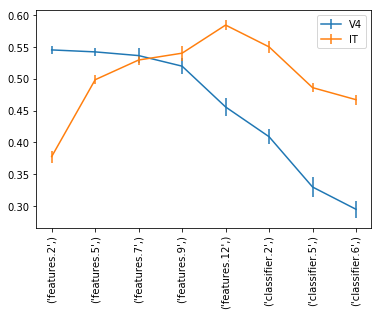

In [3]:
run_physiology(model='alexnet')

### VGG16

In [4]:
run_physiology(model='vgg16')

### ResNet50

INFO:neural_metrics.metrics.physiology:Processing /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/resnet50-weights_imagenet-activations.pkl


INFO:neural_metrics.metrics.physiology:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/resnet50-weights_imagenet-activations-correlations-region_V4-variance_V6.pkl


INFO:neural_metrics.metrics.physiology:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/resnet50-weights_imagenet-activations-correlations-region_IT-variance_V6.pkl


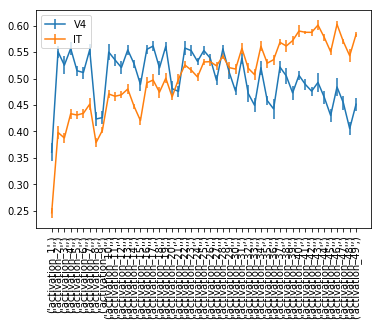

In [2]:
run_physiology(model='resnet50')

## Averaged

In [6]:
import os
from collections import defaultdict

from matplotlib import pyplot
import numpy as np

from neural_metrics import models
from neural_metrics.metrics.physiology import SimilarityWorker, _layer_correlation_meanstd

region_rellayer_scores = defaultdict(dict)

for model in ['alexnet', 'vgg16', 'resnet50', 'inception_v3', 'densenet']:
    print("Model {}".format(model))
    activations_filepath = models.get_savepath(model)
    assert os.path.isfile(activations_filepath)

    similarities = SimilarityWorker(activations_filepath, regions=('V4', 'IT'))
    for region in ['V4', 'IT']:
        print("Region {}".format(region))
        for i, layer in enumerate(similarities.get_model_layers()):
            relative_position = i / len(similarities.get_model_layers())
            _similarities = similarities(layers=[layer], region=region, return_raw=True)
            mean, std = _layer_correlation_meanstd(_similarities)
            region_rellayer_scores[region][relative_position] = mean, std

Model alexnet


Region V4
Region IT
Model vgg16


Region V4
Region IT
Model resnet50


Region V4
Region IT
Model inception_v3


Region V4
Region IT
Model densenet


Region V4
Region IT


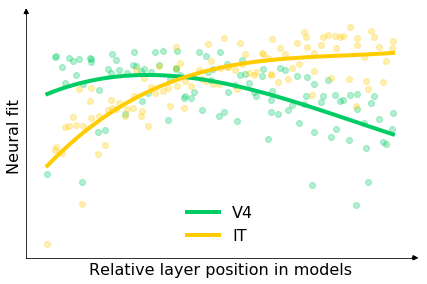

In [9]:
from collections import OrderedDict
from neural_metrics.plot import arrowed_spines, area_color_mapping

for region in ['V4', 'IT']:
    relative_scores = region_rellayer_scores[region]
    relative_scores = OrderedDict((relative, score) for relative, score in
                                  sorted(zip(relative_scores.keys(), relative_scores.values()), key=lambda kv: kv[0]))
    x = list(relative_scores.keys())
    y = np.array([mean for mean, std in relative_scores.values()])
    z = np.polyfit(x, y, 3)
    f = np.poly1d(z)
    y_fit = f(x)

    pyplot.plot(x, y_fit, color=area_color_mapping[region], linewidth=4., label=region)
    pyplot.scatter(x, y, color=area_color_mapping[region], alpha=0.3)

    for spine in ['top', 'right']:
        pyplot.gca().spines[spine].set_visible(False)
    pyplot.gca().xaxis.set_ticks([])
    pyplot.gca().yaxis.set_ticks([])
    arrowed_spines()
    pyplot.xlabel('Relative layer position in models', fontsize=16)
    pyplot.ylabel('Neural fit', fontsize=16)
pyplot.legend(frameon=False, prop={'size': 16})
pyplot.tight_layout()
pyplot.savefig('results/layer-v-fit.svg', transparent=True)
